In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
import optuna
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
SEED = 1234
tf.keras.utils.set_random_seed(SEED)

In [ ]:
# 1. Preparación de los Datos
# Cargar el dataset CIFAR-10
(X_entrenamiento, y_entrenamiento), (X_prueba, y_prueba) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Normalizar las imágenes
X_entrenamiento = X_entrenamiento.astype('float32') / 255.0
X_prueba = X_prueba.astype('float32') / 255.0

In [ ]:
# Convertir las etiquetas a formato one-hot
y_entrenamiento = to_categorical(y_entrenamiento, 10)
y_prueba = to_categorical(y_prueba, 10)

In [ ]:
# 2. Arquitectura del Modelo y 3. Optimización de Hiperparámetros con Optuna
def objetivo(trial):
    # Sugerir hiperparámetros
    num_filtros = trial.suggest_categorical('num_filtros', [32, 64, 128])
    kernel_size = trial.suggest_categorical('kernel_size', [(3, 3), (5, 5)])
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)

    # Definir la arquitectura del modelo CNN
    modelo = Sequential()
    modelo.add(Conv2D(num_filtros, kernel_size=kernel_size, activation='relu', input_shape=(32, 32, 3)))
    modelo.add(MaxPooling2D(pool_size=(2, 2)))
    modelo.add(Dropout(dropout_rate))

    modelo.add(Flatten())
    modelo.add(Dense(128, activation='relu'))
    modelo.add(Dropout(dropout_rate))
    modelo.add(Dense(10, activation='softmax'))

    # Compilar el modelo
    modelo.compile(optimizer=Adam(),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

    # Entrenar el modelo
    modelo.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_prueba, y_prueba),
               epochs=10, batch_size=64, verbose=0)

    # Evaluar en prueba
    _, val_accuracy = modelo.evaluate(X_prueba, y_prueba, verbose=0)

    # Maximizar la precisión en este caso
    return 1.0 - val_accuracy

In [ ]:
# Crear el estudio de Optuna
estudio = optuna.create_study(direction='minimize')
estudio.optimize(objetivo, n_trials=10)

[I 2024-10-31 04:43:33,366] A new study created in memory with name: no-name-c9dc96eb-ba1c-4caa-9e17-2fe5a9b30521
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (3, 3) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (5, 5) which is of type tuple.
  warnings.warn(message)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2024-10-

In [ ]:
# Mostrar los mejores hiperparámetros encontrados
mejores_params = estudio.best_params
print("Mejores hiperparámetros encontrados:", mejores_params)

Mejores hiperparámetros encontrados: {'num_filtros': 32, 'kernel_size': (5, 5), 'dropout_rate': 0.34581960587906074}


In [ ]:
# 4. Entrenamiento y Evaluación del Modelo Final
modelo_final = Sequential()
modelo_final.add(Conv2D(mejores_params['num_filtros'],
                        kernel_size=mejores_params['kernel_size'],
                        activation='relu', input_shape=(32, 32, 3)))
modelo_final.add(MaxPooling2D(pool_size=(2, 2)))
modelo_final.add(Dropout(mejores_params['dropout_rate']))

modelo_final.add(Flatten())
modelo_final.add(Dense(128, activation='relu'))
modelo_final.add(Dropout(mejores_params['dropout_rate']))
modelo_final.add(Dense(10, activation='softmax'))

modelo_final.compile(optimizer=Adam(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])


In [ ]:
# Entrenar el modelo final
historial = modelo_final.fit(X_entrenamiento, y_entrenamiento, validation_data=(X_prueba, y_prueba),
                             epochs=10, batch_size=64, verbose=1)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 68ms/step - accuracy: 0.3523 - loss: 1.7741 - val_accuracy: 0.5418 - val_loss: 1.3058
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - accuracy: 0.5130 - loss: 1.3674 - val_accuracy: 0.5673 - val_loss: 1.2197
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 68ms/step - accuracy: 0.5516 - loss: 1.2677 - val_accuracy: 0.5842 - val_loss: 1.1679
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 68ms/step - accuracy: 0.5774 - loss: 1.1877 - val_accuracy: 0.5982 - val_loss: 1.1452
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 52s 67ms/step - accuracy: 0.5962 - loss: 1.1294 - val_accuracy: 0.6182 - val_loss: 1.0875
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - accuracy: 0.6174 - loss: 1.0836 - val_accuracy: 0.6351 - val_loss: 1.0590
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 83s 68ms/step - accuracy: 0.6314 - loss: 1.0436 - val_accuracy: 0.6327 - val_loss: 1.0515
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - accuracy: 0.6430 - loss: 1.0136 - 

In [ ]:
# Evaluar el modelo en el conjunto de prueba
accuracy = modelo_final.evaluate(X_prueba, y_prueba, verbose=0)
print(f'Precisión en prueba: {accuracy[1]:.4f}')

Precisión en prueba: 0.6509


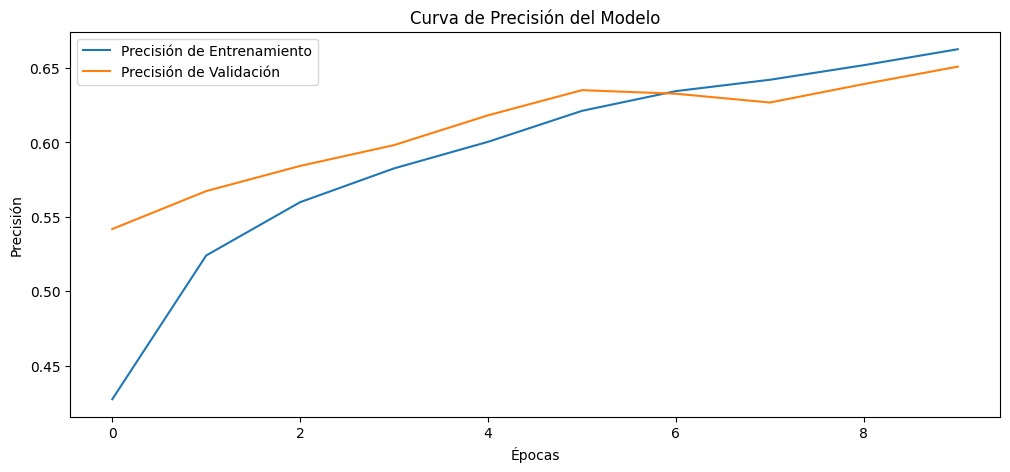

In [ ]:
# 5. Visualización de Resultados
# Curvas de aprendizaje
plt.figure(figsize=(12, 5))
plt.plot(historial.history['accuracy'], label='Precisión de Entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Precisión de Validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.title('Curva de Precisión del Modelo')
plt.show()

In [ ]:
# Matriz de confusión
y_pred = np.argmax(modelo_final.predict(X_prueba), axis=1)
y_true = np.argmax(y_prueba, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


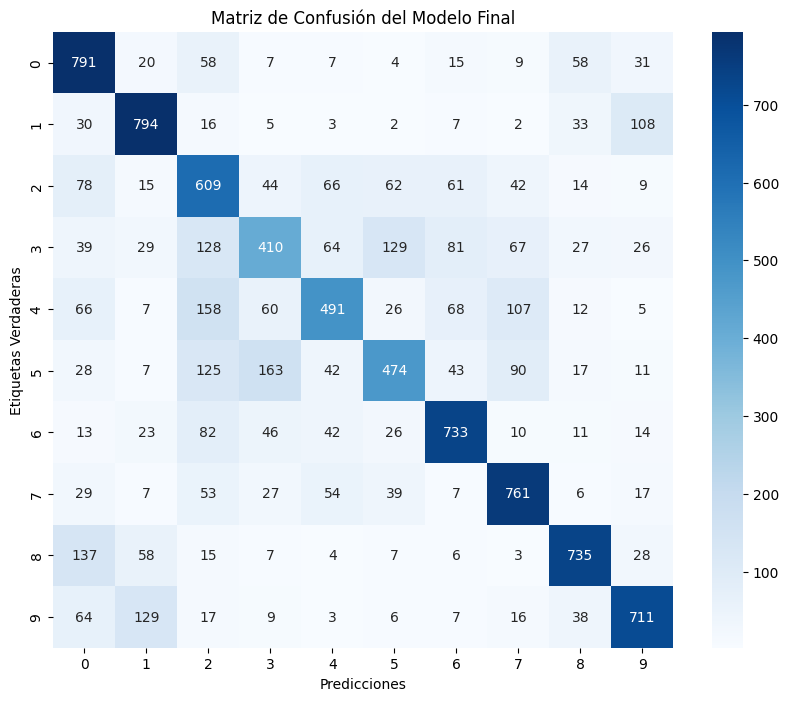

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Verdaderas')
plt.title('Matriz de Confusión del Modelo Final')
plt.show()

In [ ]:
# Top 10 experimentos de Optuna
top_trials = sorted(estudio.trials, key=lambda t: t.value)[:10]
print("Top 10 mejores configuraciones de hiperparámetros:")
for i, trial in enumerate(top_trials):
    print(f"Configuración {i+1}: {trial.params}, Precisión: {1 - trial.value:.4f}")

Top 10 mejores configuraciones de hiperparámetros:
Configuración 1: {'num_filtros': 32, 'kernel_size': (5, 5), 'dropout_rate': 0.34581960587906074}, Precisión: 0.6545
Configuración 2: {'num_filtros': 64, 'kernel_size': (5, 5), 'dropout_rate': 0.2419449154455812}, Precisión: 0.6466
Configuración 3: {'num_filtros': 64, 'kernel_size': (5, 5), 'dropout_rate': 0.3655181019255048}, Precisión: 0.6459
Configuración 4: {'num_filtros': 128, 'kernel_size': (5, 5), 'dropout_rate': 0.2522273164937076}, Precisión: 0.6454
Configuración 5: {'num_filtros': 32, 'kernel_size': (3, 3), 'dropout_rate': 0.2909113639844348}, Precisión: 0.6368
Configuración 6: {'num_filtros': 64, 'kernel_size': (3, 3), 'dropout_rate': 0.3980325281335847}, Precisión: 0.6345
Configuración 7: {'num_filtros': 128, 'kernel_size': (5, 5), 'dropout_rate': 0.2861710287262482}, Precisión: 0.6335
Configuración 8: {'num_filtros': 32, 'kernel_size': (3, 3), 'dropout_rate': 0.46612625249397516}, Precisión: 0.6335
Configuración 9: {'num_fi